# Review Classification

## Torchtext Processing and Bidirectional LSTM

### Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

% cd 'drive/My Drive/Natural Language processing/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Natural Language processing


In [ ]:
import pandas as pd # Loading data
import numpy as np
import warnings
from sklearn.model_selection import train_test_split # train test splits

warnings.filterwarnings('ignore')

### Data Loading and Processing

We will first do all the necessary pre-processing before starting to create batches and training the model. All the steps are explained in the notebook named `Text Cleaning.ipynb`

In [3]:
# Read dataset
data = pd.read_csv("Reviews.csv")
# Drop unnecesary columns and duplicates
new_data = data.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'])
# Get useful columns
useful_data = new_data[['Text', 'Score']]
# Calculate length of each sentence without tokenizer
useful_data['sudo_length'] = useful_data.Text.str.split().str.len()
# Filter examples by length
useful_data = useful_data[(useful_data.sudo_length > 20) & (useful_data.sudo_length < 100)]
# Remove length column
useful_data = useful_data.drop(['sudo_length'], axis = 1)
# print 5 rows
useful_data.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


#### Create Train and Test sets

In [ ]:
train, test = train_test_split(useful_data, test_size = 0.2)
train.to_csv("./train_test_data/train.csv", index=False)
test.to_csv("./train_test_data/test.csv", index=False)

In [ ]:
import torchtext
from torchtext.data import TabularDataset, Field, BucketIterator
import spacy

In [ ]:
tok = spacy.load('en_core_web_sm')

In [ ]:
def tokenize_en(sent):
    sent = sent.lower()
    return [item.text for item in tok.tokenizer(sent)]

In [8]:
sent = "hello their, why don't u have a seat?"
tokenize_en(sent)

['hello', 'their', ',', 'why', 'do', "n't", 'u', 'have', 'a', 'seat', '?']

In [ ]:
SENT_FIELD = Field(sequential=True, tokenize=tokenize_en)
LABEL_FIELD = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

data_fields = [
    ('Text', SENT_FIELD),
    ('Score', LABEL_FIELD)
]

In [ ]:
train, val = TabularDataset.splits(
    path='./train_test_data',
    train='train.csv',
    validation = 'test.csv',
    format='csv',
    skip_header=True,
    fields=data_fields
)

In [11]:
SENT_FIELD.build_vocab(train)
SENT_FIELD.vocab.load_vectors('glove.6B.300d')

print("Number of words : {}".format(len(SENT_FIELD.vocab)))

Number of words : 101902


In [ ]:
BATCH_SIZE = 64
dev = 'cuda'

train_iter, val_iter = BucketIterator.splits(
    (train, val), 
    batch_sizes=(BATCH_SIZE, BATCH_SIZE), 
    sort_key=lambda x: len(x.Text), 
    shuffle=True, 
    sort_within_batch=True,
    repeat=False,
    device = dev
)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as opt
from sklearn.metrics import confusion_matrix

In [ ]:
class ClassificationMetrics:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.classes = list(range(num_classes))
        self.epsilon = 1e-12
        self.cmatrix = np.zeros((num_classes, num_classes), dtype = np.int64) + self.epsilon
        
        self.total_correct = 0
        self.total_examples = 0
        
    def update(self, pred, truth):
        pred = pred.cpu()
        truth = truth.cpu()
        
        _, idx = pred.topk(1)
        truth = truth.view(-1, 1)
        
        self.total_examples += len(truth)
        self.total_correct += sum(idx == truth).item()
        
        val = confusion_matrix(truth, idx, labels=self.classes)
        
        self.cmatrix = self.cmatrix + val
        
        
    def precision_score(self):
        scores = {}
        for i in range(self.num_classes):
            scores[i] = self.cmatrix[i, i] / (sum(self.cmatrix[:, i]) + self.epsilon)
        
        return scores
    
    def recall_score(self):
        scores = {}
        for i in range(self.num_classes):
            scores[i] = self.cmatrix[i, i] / (sum(self.cmatrix[i, :]) + self.epsilon)
        
        return scores
    
    def scores(self, return_type = 'f1'):
        pscores = self.precision_score()
        rscores = self.recall_score()
        scores = {}
        for i in range(self.num_classes):
            if(pscores[i] == 0 and rscores[i] == 0):
                scores[i] = 0
            else:
                scores[i] = 2 * ((pscores[i] * rscores[i]) / (pscores[i] + rscores[i])  + self.epsilon)
            
        if return_type == 'f1':
            return scores
        elif return_type == 'all':
            all_scores = list(zip(pscores.values(), rscores.values(), scores.values()))
            t = {}
            for i in range(self.num_classes):
                t[i] = all_scores[i]
                
            return t
        else:
            raise Exception("Invalid argument for return type")
            
    def accuracy_score(self):
        return self.total_correct / self.total_examples
    
    def reset(self):
        self.total_correct = 0
        self.total_examples = 0
        self.cmatrix = np.zeros((self.num_classes, self.num_classes))
            
    def print_report(self):
        all_scores = self.scores('all')
        print("{:^15}\t{:^15}\t{:^15}\t{:^15}".format("Class", "Precision", "Recall", "F1-score"))
        for c, values in all_scores.items():
            print("{:^15}\t{:^15.3f}\t{:^15.3f}\t{:^15.3f}".format(c, values[0], values[1], values[2]))
            
        print("Accuracy : {:.5f} %".format(self.accuracy_score()))

In [ ]:
class BiDirectionalLstm(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(BiDirectionalLstm, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.cell = nn.LSTM(embedding_dim, hidden_size, bidirectional = True, dropout = 0.2)
        self.linear = nn.Linear(hidden_size * 2, num_classes)
        self.soft = nn.Softmax(dim=1)
        
    def forward(self, x, hstate = None):
        if hstate is None:
            hstate = self.init_hidden(self.hidden_size, x.shape[-1])
            
        cell_out, _ = self.cell(self.embedding(x), hstate)
        
        temp = torch.cat([cell_out[-1, :, :self.hidden_size], cell_out[0, :, self.hidden_size:]], axis = -1)
        
        out = self.linear(temp)
        
        return out
            
    def init_hidden(self, hidden_size, bs):
        return (torch.zeros(2, bs, hidden_size, device=dev), torch.zeros(2, bs, hidden_size, device=dev))
    
    def load_embeddings(self, embeddings):
        self.embedding.weight.data.copy_(embeddings)

In [ ]:
VOCAB_SIZE = len(SENT_FIELD.vocab)
EMBEDDING_DIM = 300
HIDDEN_SIZE = 128
NUM_CLASSES = 5

In [ ]:
import pandas as pd
from sklearn.utils import class_weight

train = pd.read_csv("./train_test_data/train.csv")
weight_array = class_weight.compute_class_weight('balanced', sorted(train.Score.unique()), train.Score)
del(train)

In [ ]:
net = BiDirectionalLstm(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, NUM_CLASSES)
net.load_embeddings(SENT_FIELD.vocab.vectors)
net = net.cuda()
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(weight_array).to(dev))

optimizer = opt.SGD(net.parameters(), lr=0.01)

scheduler = opt.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.0)

In [ ]:
train_metrics = ClassificationMetrics(NUM_CLASSES)
val_metrics = ClassificationMetrics(NUM_CLASSES)

In [20]:
from tqdm.notebook import tqdm
import copy
N_EPOCH = 50

tloss = []
tacc = []
vloss = []
vacc = []

best_val_acc = 0
best_model = copy.deepcopy(net)

for epoch in range(N_EPOCH):
    train_metrics.reset()
    losses = []
    net.train()
    for batch in tqdm(train_iter):
        optimizer.zero_grad()
        labels = batch.Score - 1
        pred = net(batch.Text)

        loss = criterion(pred, labels)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        train_metrics.update(pred, labels)
    
    print("Training Run\nEpoch : {} Loss : {:.5f}".format(epoch + 1, sum(losses) / len(losses)))
    train_metrics.print_report()
    tloss.append(sum(losses) / len(losses))
    tacc.append(train_metrics.accuracy_score() * 100)
    
    val_metrics.reset()
    val_losses = []
    net.eval()
    for batch in tqdm(val_iter):
        labels = batch.Score - 1
        pred = net(batch.Text)
        loss = criterion(pred, labels)
        val_losses.append(loss.item())
        val_metrics.update(pred, labels)
        
    print("Validation Run\nEpoch : {} Loss : {:.5f}".format(epoch + 1, sum(val_losses) / len(val_losses)))
    val_metrics.print_report()
    acc = val_metrics.accuracy_score() * 100
    vloss.append(sum(val_losses) / len(val_losses))
    vacc.append(acc)
    
    if(acc > best_val_acc):
        print("##\nNew Best Accuracy : {:.5f}\n##".format(acc))
        best_val_acc = acc
        best_model = copy.deepcopy(net)
        torch.save(best_model.state_dict(), "./models/network-val-acc-{:.2f}.pt".format(best_val_acc))
        print("Best model saved.")
        
    scheduler.step()


Training Run
Epoch : 1 Loss : 1.58864
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.169     	     0.180     	     0.174     
       1       	     0.075     	     0.189     	     0.107     
       2       	     0.106     	     0.166     	     0.130     
       3       	     0.152     	     0.330     	     0.208     
       4       	     0.752     	     0.443     	     0.557     
Accuracy : 0.37243 %



Validation Run
Epoch : 1 Loss : 1.56156
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.240     	     0.147     	     0.183     
       1       	     0.081     	     0.451     	     0.137     
       2       	     0.143     	     0.128     	     0.135     
       3       	     0.162     	     0.290     	     0.208     
       4       	     0.788     	     0.442     	     0.566     
Accuracy : 0.37435 %
##
New Best Accuracy : 37.43537
##
Best model saved.



Training Run
Epoch : 2 Loss : 1.52002
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.223     	     0.356     	     0.274     
       1       	     0.091     	     0.261     	     0.135     
       2       	     0.132     	     0.194     	     0.157     
       3       	     0.166     	     0.266     	     0.205     
       4       	     0.808     	     0.491     	     0.611     
Accuracy : 0.41792 %



Validation Run
Epoch : 2 Loss : 1.41753
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.331     	     0.372     	     0.350     
       1       	     0.136     	     0.297     	     0.187     
       2       	     0.162     	     0.308     	     0.213     
       3       	     0.185     	     0.227     	     0.204     
       4       	     0.846     	     0.640     	     0.729     
Accuracy : 0.52223 %
##
New Best Accuracy : 52.22337
##
Best model saved.



Training Run
Epoch : 3 Loss : 1.38161
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.331     	     0.568     	     0.418     
       1       	     0.139     	     0.236     	     0.175     
       2       	     0.148     	     0.231     	     0.180     
       3       	     0.186     	     0.259     	     0.217     
       4       	     0.856     	     0.611     	     0.713     
Accuracy : 0.51655 %



Validation Run
Epoch : 3 Loss : 1.32755
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.405     	     0.611     	     0.487     
       1       	     0.184     	     0.221     	     0.201     
       2       	     0.191     	     0.195     	     0.193     
       3       	     0.234     	     0.217     	     0.225     
       4       	     0.839     	     0.776     	     0.807     
Accuracy : 0.62174 %
##
New Best Accuracy : 62.17416
##
Best model saved.



Training Run
Epoch : 4 Loss : 1.30085
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.387     	     0.616     	     0.475     
       1       	     0.164     	     0.268     	     0.204     
       2       	     0.180     	     0.311     	     0.228     
       3       	     0.214     	     0.296     	     0.248     
       4       	     0.876     	     0.629     	     0.732     
Accuracy : 0.54527 %



Validation Run
Epoch : 4 Loss : 1.24592
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.453     	     0.595     	     0.514     
       1       	     0.184     	     0.376     	     0.247     
       2       	     0.206     	     0.328     	     0.253     
       3       	     0.226     	     0.307     	     0.260     
       4       	     0.888     	     0.662     	     0.759     
Accuracy : 0.57310 %



Training Run
Epoch : 5 Loss : 1.25280
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.419     	     0.627     	     0.503     
       1       	     0.190     	     0.302     	     0.234     
       2       	     0.206     	     0.343     	     0.258     
       3       	     0.228     	     0.326     	     0.269     
       4       	     0.886     	     0.650     	     0.750     
Accuracy : 0.56791 %



Validation Run
Epoch : 5 Loss : 1.25784
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.341     	     0.684     	     0.455     
       1       	     0.160     	     0.421     	     0.232     
       2       	     0.185     	     0.309     	     0.231     
       3       	     0.207     	     0.332     	     0.255     
       4       	     0.921     	     0.505     	     0.653     
Accuracy : 0.48187 %



Training Run
Epoch : 6 Loss : 1.22307
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.440     	     0.637     	     0.520     
       1       	     0.203     	     0.313     	     0.246     
       2       	     0.223     	     0.354     	     0.273     
       3       	     0.237     	     0.348     	     0.282     
       4       	     0.891     	     0.662     	     0.760     
Accuracy : 0.58082 %



Validation Run
Epoch : 6 Loss : 1.29010
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.295     	     0.783     	     0.429     
       1       	     0.143     	     0.393     	     0.209     
       2       	     0.170     	     0.253     	     0.203     
       3       	     0.214     	     0.249     	     0.230     
       4       	     0.924     	     0.512     	     0.659     
Accuracy : 0.47951 %



Training Run
Epoch : 7 Loss : 1.19856
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.464     	     0.646     	     0.540     
       1       	     0.215     	     0.331     	     0.261     
       2       	     0.234     	     0.370     	     0.287     
       3       	     0.243     	     0.361     	     0.291     
       4       	     0.894     	     0.670     	     0.766     
Accuracy : 0.59035 %



Validation Run
Epoch : 7 Loss : 1.18003
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.483     	     0.663     	     0.559     
       1       	     0.222     	     0.338     	     0.268     
       2       	     0.250     	     0.348     	     0.291     
       3       	     0.244     	     0.391     	     0.300     
       4       	     0.902     	     0.677     	     0.773     
Accuracy : 0.59956 %



Training Run
Epoch : 8 Loss : 1.18127
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.476     	     0.650     	     0.550     
       1       	     0.219     	     0.331     	     0.264     
       2       	     0.243     	     0.381     	     0.296     
       3       	     0.248     	     0.370     	     0.297     
       4       	     0.897     	     0.678     	     0.772     
Accuracy : 0.59768 %



Validation Run
Epoch : 8 Loss : 1.19529
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.461     	     0.628     	     0.532     
       1       	     0.186     	     0.467     	     0.266     
       2       	     0.198     	     0.388     	     0.262     
       3       	     0.201     	     0.376     	     0.262     
       4       	     0.929     	     0.526     	     0.672     
Accuracy : 0.50389 %



Training Run
Epoch : 9 Loss : 1.16620
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.492     	     0.655     	     0.562     
       1       	     0.228     	     0.343     	     0.274     
       2       	     0.252     	     0.388     	     0.305     
       3       	     0.251     	     0.380     	     0.302     
       4       	     0.899     	     0.683     	     0.776     
Accuracy : 0.60398 %



Validation Run
Epoch : 9 Loss : 1.17524
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.420     	     0.726     	     0.532     
       1       	     0.190     	     0.377     	     0.253     
       2       	     0.224     	     0.346     	     0.272     
       3       	     0.237     	     0.339     	     0.279     
       4       	     0.916     	     0.626     	     0.743     
Accuracy : 0.56654 %



Training Run
Epoch : 10 Loss : 1.15133
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.505     	     0.654     	     0.570     
       1       	     0.233     	     0.355     	     0.281     
       2       	     0.258     	     0.393     	     0.312     
       3       	     0.255     	     0.386     	     0.307     
       4       	     0.901     	     0.689     	     0.781     
Accuracy : 0.60957 %



Validation Run
Epoch : 10 Loss : 1.15088
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.517     	     0.610     	     0.560     
       1       	     0.210     	     0.462     	     0.289     
       2       	     0.235     	     0.390     	     0.293     
       3       	     0.221     	     0.433     	     0.293     
       4       	     0.927     	     0.583     	     0.716     
Accuracy : 0.54702 %



Training Run
Epoch : 11 Loss : 1.13884
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.514     	     0.664     	     0.579     
       1       	     0.239     	     0.354     	     0.285     
       2       	     0.265     	     0.401     	     0.319     
       3       	     0.258     	     0.398     	     0.313     
       4       	     0.903     	     0.689     	     0.781     
Accuracy : 0.61239 %



Validation Run
Epoch : 11 Loss : 1.18509
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.402     	     0.840     	     0.544     
       1       	     0.205     	     0.252     	     0.226     
       2       	     0.284     	     0.219     	     0.247     
       3       	     0.322     	     0.239     	     0.274     
       4       	     0.883     	     0.798     	     0.838     
Accuracy : 0.66286 %
##
New Best Accuracy : 66.28570
##
Best model saved.



Training Run
Epoch : 12 Loss : 1.12578
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.527     	     0.661     	     0.586     
       1       	     0.249     	     0.367     	     0.297     
       2       	     0.271     	     0.409     	     0.326     
       3       	     0.259     	     0.401     	     0.315     
       4       	     0.904     	     0.695     	     0.785     
Accuracy : 0.61769 %



Validation Run
Epoch : 12 Loss : 1.12405
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.540     	     0.686     	     0.604     
       1       	     0.264     	     0.330     	     0.293     
       2       	     0.287     	     0.364     	     0.321     
       3       	     0.280     	     0.384     	     0.324     
       4       	     0.896     	     0.756     	     0.820     
Accuracy : 0.65371 %



Training Run
Epoch : 13 Loss : 1.11278
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.538     	     0.666     	     0.595     
       1       	     0.257     	     0.378     	     0.306     
       2       	     0.276     	     0.417     	     0.332     
       3       	     0.262     	     0.410     	     0.319     
       4       	     0.905     	     0.694     	     0.786     
Accuracy : 0.62026 %



Validation Run
Epoch : 13 Loss : 1.11468
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.554     	     0.692     	     0.615     
       1       	     0.289     	     0.260     	     0.274     
       2       	     0.294     	     0.438     	     0.351     
       3       	     0.275     	     0.402     	     0.326     
       4       	     0.899     	     0.748     	     0.816     
Accuracy : 0.65255 %



Training Run
Epoch : 14 Loss : 1.10173
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.545     	     0.664     	     0.599     
       1       	     0.262     	     0.375     	     0.309     
       2       	     0.280     	     0.426     	     0.338     
       3       	     0.265     	     0.417     	     0.324     
       4       	     0.906     	     0.699     	     0.789     
Accuracy : 0.62434 %



Validation Run
Epoch : 14 Loss : 1.11091
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.568     	     0.684     	     0.620     
       1       	     0.277     	     0.337     	     0.304     
       2       	     0.333     	     0.332     	     0.333     
       3       	     0.305     	     0.404     	     0.348     
       4       	     0.889     	     0.792     	     0.838     
Accuracy : 0.67819 %
##
New Best Accuracy : 67.81906
##
Best model saved.



Training Run
Epoch : 15 Loss : 1.09074
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.558     	     0.667     	     0.607     
       1       	     0.271     	     0.395     	     0.321     
       2       	     0.282     	     0.423     	     0.338     
       3       	     0.269     	     0.424     	     0.329     
       4       	     0.908     	     0.703     	     0.792     
Accuracy : 0.62886 %



Validation Run
Epoch : 15 Loss : 1.09697
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.525     	     0.685     	     0.595     
       1       	     0.272     	     0.398     	     0.323     
       2       	     0.248     	     0.449     	     0.319     
       3       	     0.247     	     0.408     	     0.307     
       4       	     0.921     	     0.655     	     0.766     
Accuracy : 0.59912 %



Training Run
Epoch : 16 Loss : 1.08148
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.565     	     0.671     	     0.614     
       1       	     0.280     	     0.403     	     0.331     
       2       	     0.291     	     0.432     	     0.348     
       3       	     0.268     	     0.429     	     0.330     
       4       	     0.908     	     0.702     	     0.792     
Accuracy : 0.63078 %



Validation Run
Epoch : 16 Loss : 1.08305
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.553     	     0.674     	     0.607     
       1       	     0.268     	     0.405     	     0.323     
       2       	     0.277     	     0.427     	     0.336     
       3       	     0.301     	     0.345     	     0.322     
       4       	     0.903     	     0.764     	     0.828     
Accuracy : 0.66088 %



Training Run
Epoch : 17 Loss : 1.07108
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.567     	     0.669     	     0.613     
       1       	     0.283     	     0.399     	     0.331     
       2       	     0.293     	     0.433     	     0.349     
       3       	     0.275     	     0.436     	     0.337     
       4       	     0.909     	     0.708     	     0.796     
Accuracy : 0.63511 %



Validation Run
Epoch : 17 Loss : 1.12390
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.704     	     0.503     	     0.586     
       1       	     0.295     	     0.349     	     0.320     
       2       	     0.320     	     0.447     	     0.373     
       3       	     0.289     	     0.481     	     0.361     
       4       	     0.898     	     0.768     	     0.828     
Accuracy : 0.66377 %



Training Run
Epoch : 18 Loss : 1.06312
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.575     	     0.666     	     0.617     
       1       	     0.288     	     0.410     	     0.338     
       2       	     0.297     	     0.438     	     0.354     
       3       	     0.274     	     0.435     	     0.336     
       4       	     0.909     	     0.710     	     0.798     
Accuracy : 0.63708 %



Validation Run
Epoch : 18 Loss : 1.08810
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.612     	     0.573     	     0.592     
       1       	     0.268     	     0.421     	     0.328     
       2       	     0.237     	     0.563     	     0.333     
       3       	     0.239     	     0.368     	     0.290     
       4       	     0.921     	     0.662     	     0.771     
Accuracy : 0.59719 %



Training Run
Epoch : 19 Loss : 1.05565
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.579     	     0.673     	     0.622     
       1       	     0.293     	     0.412     	     0.343     
       2       	     0.303     	     0.446     	     0.361     
       3       	     0.276     	     0.438     	     0.338     
       4       	     0.910     	     0.712     	     0.799     
Accuracy : 0.63995 %



Validation Run
Epoch : 19 Loss : 1.06804
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.585     	     0.665     	     0.623     
       1       	     0.277     	     0.441     	     0.341     
       2       	     0.322     	     0.360     	     0.340     
       3       	     0.316     	     0.394     	     0.351     
       4       	     0.900     	     0.788     	     0.840     
Accuracy : 0.67933 %
##
New Best Accuracy : 67.93317
##
Best model saved.



Training Run
Epoch : 20 Loss : 1.04810
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.587     	     0.670     	     0.626     
       1       	     0.300     	     0.425     	     0.352     
       2       	     0.309     	     0.454     	     0.368     
       3       	     0.279     	     0.446     	     0.343     
       4       	     0.911     	     0.714     	     0.801     
Accuracy : 0.64287 %



Validation Run
Epoch : 20 Loss : 1.07884
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.531     	     0.684     	     0.598     
       1       	     0.241     	     0.467     	     0.318     
       2       	     0.270     	     0.378     	     0.315     
       3       	     0.314     	     0.316     	     0.315     
       4       	     0.906     	     0.767     	     0.831     
Accuracy : 0.65984 %



Training Run
Epoch : 21 Loss : 1.04087
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.593     	     0.676     	     0.631     
       1       	     0.304     	     0.422     	     0.353     
       2       	     0.312     	     0.455     	     0.370     
       3       	     0.282     	     0.451     	     0.347     
       4       	     0.912     	     0.716     	     0.802     
Accuracy : 0.64584 %



Validation Run
Epoch : 21 Loss : 1.07230
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.661     	     0.563     	     0.608     
       1       	     0.293     	     0.498     	     0.369     
       2       	     0.321     	     0.366     	     0.342     
       3       	     0.316     	     0.407     	     0.356     
       4       	     0.896     	     0.804     	     0.847     
Accuracy : 0.68545 %
##
New Best Accuracy : 68.54473
##
Best model saved.



Training Run
Epoch : 22 Loss : 1.03539
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.595     	     0.677     	     0.633     
       1       	     0.307     	     0.427     	     0.358     
       2       	     0.310     	     0.453     	     0.368     
       3       	     0.285     	     0.454     	     0.350     
       4       	     0.913     	     0.718     	     0.804     
Accuracy : 0.64751 %



Validation Run
Epoch : 22 Loss : 1.05480
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.627     	     0.615     	     0.621     
       1       	     0.291     	     0.458     	     0.355     
       2       	     0.300     	     0.427     	     0.353     
       3       	     0.286     	     0.451     	     0.350     
       4       	     0.914     	     0.733     	     0.814     
Accuracy : 0.65143 %



Training Run
Epoch : 23 Loss : 1.02855
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.598     	     0.684     	     0.638     
       1       	     0.315     	     0.433     	     0.365     
       2       	     0.317     	     0.462     	     0.376     
       3       	     0.286     	     0.457     	     0.352     
       4       	     0.913     	     0.719     	     0.805     
Accuracy : 0.65026 %



Validation Run
Epoch : 23 Loss : 1.10374
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.714     	     0.458     	     0.558     
       1       	     0.289     	     0.322     	     0.305     
       2       	     0.291     	     0.593     	     0.390     
       3       	     0.236     	     0.574     	     0.334     
       4       	     0.931     	     0.609     	     0.736     
Accuracy : 0.57499 %



Training Run
Epoch : 24 Loss : 1.02299
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.602     	     0.677     	     0.637     
       1       	     0.311     	     0.435     	     0.363     
       2       	     0.321     	     0.466     	     0.380     
       3       	     0.286     	     0.456     	     0.351     
       4       	     0.913     	     0.720     	     0.805     
Accuracy : 0.65035 %



Validation Run
Epoch : 24 Loss : 1.05215
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.586     	     0.668     	     0.625     
       1       	     0.313     	     0.339     	     0.325     
       2       	     0.264     	     0.563     	     0.360     
       3       	     0.258     	     0.441     	     0.325     
       4       	     0.926     	     0.666     	     0.775     
Accuracy : 0.61379 %



Training Run
Epoch : 25 Loss : 1.01753
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.606     	     0.682     	     0.642     
       1       	     0.315     	     0.434     	     0.365     
       2       	     0.322     	     0.467     	     0.381     
       3       	     0.290     	     0.463     	     0.357     
       4       	     0.914     	     0.723     	     0.807     
Accuracy : 0.65345 %



Validation Run
Epoch : 25 Loss : 1.04983
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.573     	     0.722     	     0.639     
       1       	     0.311     	     0.316     	     0.313     
       2       	     0.320     	     0.455     	     0.376     
       3       	     0.336     	     0.356     	     0.346     
       4       	     0.897     	     0.814     	     0.853     
Accuracy : 0.69702 %
##
New Best Accuracy : 69.70189
##
Best model saved.



Training Run
Epoch : 26 Loss : 1.01300
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.609     	     0.683     	     0.644     
       1       	     0.321     	     0.444     	     0.373     
       2       	     0.324     	     0.467     	     0.383     
       3       	     0.290     	     0.462     	     0.356     
       4       	     0.914     	     0.723     	     0.807     
Accuracy : 0.65439 %



Validation Run
Epoch : 26 Loss : 1.05666
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.582     	     0.724     	     0.646     
       1       	     0.328     	     0.312     	     0.320     
       2       	     0.353     	     0.396     	     0.373     
       3       	     0.335     	     0.407     	     0.367     
       4       	     0.895     	     0.819     	     0.855     
Accuracy : 0.70288 %
##
New Best Accuracy : 70.28849
##
Best model saved.



Training Run
Epoch : 27 Loss : 1.00764
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.612     	     0.684     	     0.646     
       1       	     0.323     	     0.444     	     0.374     
       2       	     0.331     	     0.479     	     0.392     
       3       	     0.292     	     0.465     	     0.359     
       4       	     0.915     	     0.726     	     0.809     
Accuracy : 0.65727 %



Validation Run
Epoch : 27 Loss : 1.03773
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.612     	     0.649     	     0.630     
       1       	     0.292     	     0.461     	     0.358     
       2       	     0.324     	     0.392     	     0.355     
       3       	     0.287     	     0.492     	     0.363     
       4       	     0.918     	     0.722     	     0.808     
Accuracy : 0.65016 %



Training Run
Epoch : 28 Loss : 1.00323
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.616     	     0.683     	     0.648     
       1       	     0.325     	     0.451     	     0.378     
       2       	     0.329     	     0.472     	     0.388     
       3       	     0.293     	     0.469     	     0.361     
       4       	     0.916     	     0.726     	     0.810     
Accuracy : 0.65784 %



Validation Run
Epoch : 28 Loss : 1.03922
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.593     	     0.661     	     0.625     
       1       	     0.276     	     0.493     	     0.354     
       2       	     0.288     	     0.388     	     0.330     
       3       	     0.310     	     0.384     	     0.343     
       4       	     0.911     	     0.767     	     0.833     
Accuracy : 0.66842 %



Training Run
Epoch : 29 Loss : 0.99755
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.621     	     0.686     	     0.652     
       1       	     0.329     	     0.455     	     0.382     
       2       	     0.337     	     0.485     	     0.398     
       3       	     0.293     	     0.470     	     0.361     
       4       	     0.916     	     0.726     	     0.810     
Accuracy : 0.65897 %



Validation Run
Epoch : 29 Loss : 1.04638
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.560     	     0.695     	     0.621     
       1       	     0.284     	     0.412     	     0.336     
       2       	     0.268     	     0.461     	     0.339     
       3       	     0.248     	     0.480     	     0.327     
       4       	     0.933     	     0.630     	     0.752     
Accuracy : 0.59427 %



Training Run
Epoch : 30 Loss : 0.99351
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.623     	     0.686     	     0.653     
       1       	     0.329     	     0.459     	     0.383     
       2       	     0.335     	     0.480     	     0.394     
       3       	     0.298     	     0.471     	     0.365     
       4       	     0.916     	     0.731     	     0.813     
Accuracy : 0.66228 %



Validation Run
Epoch : 30 Loss : 1.06410
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.613     	     0.570     	     0.591     
       1       	     0.260     	     0.567     	     0.356     
       2       	     0.239     	     0.455     	     0.314     
       3       	     0.222     	     0.449     	     0.297     
       4       	     0.937     	     0.589     	     0.723     
Accuracy : 0.55900 %



Training Run
Epoch : 31 Loss : 0.98879
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.624     	     0.690     	     0.656     
       1       	     0.337     	     0.465     	     0.391     
       2       	     0.337     	     0.485     	     0.398     
       3       	     0.299     	     0.474     	     0.366     
       4       	     0.917     	     0.730     	     0.813     
Accuracy : 0.66322 %



Validation Run
Epoch : 31 Loss : 1.05193
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.666     	     0.574     	     0.617     
       1       	     0.321     	     0.335     	     0.328     
       2       	     0.313     	     0.559     	     0.401     
       3       	     0.289     	     0.491     	     0.364     
       4       	     0.919     	     0.734     	     0.816     
Accuracy : 0.65624 %



Training Run
Epoch : 32 Loss : 0.98433
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.628     	     0.689     	     0.657     
       1       	     0.339     	     0.467     	     0.393     
       2       	     0.342     	     0.491     	     0.403     
       3       	     0.299     	     0.473     	     0.366     
       4       	     0.916     	     0.732     	     0.814     
Accuracy : 0.66460 %



Validation Run
Epoch : 32 Loss : 1.02886
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.567     	     0.689     	     0.622     
       1       	     0.301     	     0.436     	     0.356     
       2       	     0.310     	     0.441     	     0.364     
       3       	     0.299     	     0.446     	     0.358     
       4       	     0.921     	     0.733     	     0.816     
Accuracy : 0.65713 %



Training Run
Epoch : 33 Loss : 0.98227
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.629     	     0.687     	     0.657     
       1       	     0.336     	     0.466     	     0.391     
       2       	     0.339     	     0.487     	     0.400     
       3       	     0.299     	     0.472     	     0.367     
       4       	     0.917     	     0.733     	     0.815     
Accuracy : 0.66496 %



Validation Run
Epoch : 33 Loss : 1.04173
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.631     	     0.646     	     0.638     
       1       	     0.339     	     0.299     	     0.318     
       2       	     0.310     	     0.533     	     0.392     
       3       	     0.273     	     0.534     	     0.361     
       4       	     0.925     	     0.690     	     0.790     
Accuracy : 0.63527 %



Training Run
Epoch : 34 Loss : 0.97642
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.632     	     0.694     	     0.661     
       1       	     0.343     	     0.468     	     0.396     
       2       	     0.342     	     0.491     	     0.403     
       3       	     0.303     	     0.480     	     0.371     
       4       	     0.918     	     0.733     	     0.815     
Accuracy : 0.66689 %



Validation Run
Epoch : 34 Loss : 1.03029
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.602     	     0.668     	     0.633     
       1       	     0.291     	     0.481     	     0.363     
       2       	     0.307     	     0.379     	     0.339     
       3       	     0.330     	     0.376     	     0.352     
       4       	     0.906     	     0.801     	     0.850     
Accuracy : 0.68898 %



Training Run
Epoch : 35 Loss : 0.97335
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.633     	     0.694     	     0.662     
       1       	     0.347     	     0.474     	     0.401     
       2       	     0.343     	     0.493     	     0.405     
       3       	     0.303     	     0.481     	     0.372     
       4       	     0.918     	     0.734     	     0.816     
Accuracy : 0.66797 %



Validation Run
Epoch : 35 Loss : 1.08533
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.528     	     0.763     	     0.624     
       1       	     0.247     	     0.452     	     0.320     
       2       	     0.274     	     0.317     	     0.294     
       3       	     0.324     	     0.347     	     0.336     
       4       	     0.914     	     0.773     	     0.837     
Accuracy : 0.66988 %



Training Run
Epoch : 36 Loss : 0.96864
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.635     	     0.693     	     0.663     
       1       	     0.346     	     0.476     	     0.401     
       2       	     0.353     	     0.502     	     0.415     
       3       	     0.305     	     0.484     	     0.374     
       4       	     0.918     	     0.735     	     0.817     
Accuracy : 0.67007 %



Validation Run
Epoch : 36 Loss : 1.03653
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.551     	     0.758     	     0.638     
       1       	     0.312     	     0.381     	     0.343     
       2       	     0.349     	     0.352     	     0.350     
       3       	     0.333     	     0.426     	     0.374     
       4       	     0.908     	     0.795     	     0.848     
Accuracy : 0.69319 %



Training Run
Epoch : 37 Loss : 0.96489
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.640     	     0.693     	     0.665     
       1       	     0.350     	     0.487     	     0.408     
       2       	     0.351     	     0.500     	     0.413     
       3       	     0.305     	     0.483     	     0.374     
       4       	     0.918     	     0.735     	     0.817     
Accuracy : 0.67017 %



Validation Run
Epoch : 37 Loss : 1.03180
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.652     	     0.647     	     0.649     
       1       	     0.315     	     0.442     	     0.368     
       2       	     0.332     	     0.425     	     0.373     
       3       	     0.325     	     0.444     	     0.375     
       4       	     0.908     	     0.791     	     0.846     
Accuracy : 0.69049 %



Training Run
Epoch : 38 Loss : 0.96084
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.642     	     0.695     	     0.668     
       1       	     0.351     	     0.485     	     0.407     
       2       	     0.356     	     0.507     	     0.418     
       3       	     0.307     	     0.487     	     0.376     
       4       	     0.919     	     0.736     	     0.817     
Accuracy : 0.67187 %



Validation Run
Epoch : 38 Loss : 1.06733
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.536     	     0.792     	     0.639     
       1       	     0.287     	     0.393     	     0.332     
       2       	     0.389     	     0.241     	     0.297     
       3       	     0.362     	     0.381     	     0.371     
       4       	     0.896     	     0.837     	     0.865     
Accuracy : 0.71109 %
##
New Best Accuracy : 71.10865
##
Best model saved.



Training Run
Epoch : 39 Loss : 0.95700
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.639     	     0.703     	     0.669     
       1       	     0.353     	     0.482     	     0.408     
       2       	     0.357     	     0.506     	     0.418     
       3       	     0.307     	     0.486     	     0.377     
       4       	     0.919     	     0.736     	     0.817     
Accuracy : 0.67241 %



Validation Run
Epoch : 39 Loss : 1.02636
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.567     	     0.729     	     0.638     
       1       	     0.336     	     0.318     	     0.327     
       2       	     0.320     	     0.485     	     0.386     
       3       	     0.302     	     0.485     	     0.372     
       4       	     0.921     	     0.731     	     0.815     
Accuracy : 0.66166 %



Training Run
Epoch : 40 Loss : 0.95246
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.647     	     0.695     	     0.670     
       1       	     0.357     	     0.493     	     0.414     
       2       	     0.359     	     0.513     	     0.422     
       3       	     0.310     	     0.488     	     0.379     
       4       	     0.919     	     0.739     	     0.819     
Accuracy : 0.67493 %



Validation Run
Epoch : 40 Loss : 1.04049
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.534     	     0.742     	     0.621     
       1       	     0.300     	     0.359     	     0.327     
       2       	     0.272     	     0.502     	     0.353     
       3       	     0.307     	     0.383     	     0.341     
       4       	     0.923     	     0.733     	     0.817     
Accuracy : 0.65455 %



Training Run
Epoch : 41 Loss : 0.94925
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.647     	     0.700     	     0.672     
       1       	     0.358     	     0.494     	     0.415     
       2       	     0.361     	     0.511     	     0.423     
       3       	     0.312     	     0.493     	     0.382     
       4       	     0.920     	     0.739     	     0.820     
Accuracy : 0.67580 %



Validation Run
Epoch : 41 Loss : 1.03256
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.663     	     0.596     	     0.627     
       1       	     0.321     	     0.388     	     0.351     
       2       	     0.318     	     0.512     	     0.392     
       3       	     0.294     	     0.512     	     0.373     
       4       	     0.922     	     0.729     	     0.814     
Accuracy : 0.65672 %



Training Run
Epoch : 42 Loss : 0.94415
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.649     	     0.696     	     0.671     
       1       	     0.363     	     0.504     	     0.422     
       2       	     0.362     	     0.514     	     0.425     
       3       	     0.313     	     0.491     	     0.382     
       4       	     0.920     	     0.740     	     0.820     
Accuracy : 0.67683 %



Validation Run
Epoch : 42 Loss : 1.05024
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.615     	     0.619     	     0.617     
       1       	     0.244     	     0.610     	     0.349     
       2       	     0.265     	     0.364     	     0.307     
       3       	     0.313     	     0.368     	     0.338     
       4       	     0.921     	     0.749     	     0.826     
Accuracy : 0.65446 %



Training Run
Epoch : 43 Loss : 0.94100
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.653     	     0.702     	     0.677     
       1       	     0.365     	     0.504     	     0.424     
       2       	     0.366     	     0.518     	     0.429     
       3       	     0.313     	     0.494     	     0.383     
       4       	     0.920     	     0.741     	     0.821     
Accuracy : 0.67838 %



Validation Run
Epoch : 43 Loss : 1.03406
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.651     	     0.650     	     0.651     
       1       	     0.328     	     0.333     	     0.330     
       2       	     0.340     	     0.503     	     0.406     
       3       	     0.294     	     0.501     	     0.370     
       4       	     0.919     	     0.746     	     0.824     
Accuracy : 0.66842 %



Training Run
Epoch : 44 Loss : 0.93647
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.652     	     0.702     	     0.676     
       1       	     0.367     	     0.506     	     0.426     
       2       	     0.366     	     0.520     	     0.429     
       3       	     0.313     	     0.494     	     0.384     
       4       	     0.921     	     0.740     	     0.821     
Accuracy : 0.67825 %



Validation Run
Epoch : 44 Loss : 1.01971
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.615     	     0.657     	     0.636     
       1       	     0.294     	     0.485     	     0.366     
       2       	     0.325     	     0.392     	     0.355     
       3       	     0.324     	     0.451     	     0.377     
       4       	     0.915     	     0.772     	     0.837     
Accuracy : 0.67967 %



Training Run
Epoch : 45 Loss : 0.93352
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.656     	     0.701     	     0.678     
       1       	     0.366     	     0.507     	     0.425     
       2       	     0.368     	     0.525     	     0.433     
       3       	     0.316     	     0.494     	     0.385     
       4       	     0.921     	     0.742     	     0.822     
Accuracy : 0.67984 %



Validation Run
Epoch : 45 Loss : 1.04462
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.580     	     0.773     	     0.663     
       1       	     0.331     	     0.271     	     0.298     
       2       	     0.363     	     0.424     	     0.391     
       3       	     0.355     	     0.420     	     0.385     
       4       	     0.903     	     0.825     	     0.862     
Accuracy : 0.71307 %
##
New Best Accuracy : 71.30656
##
Best model saved.



Training Run
Epoch : 46 Loss : 0.92866
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.658     	     0.705     	     0.681     
       1       	     0.369     	     0.513     	     0.429     
       2       	     0.372     	     0.524     	     0.435     
       3       	     0.316     	     0.497     	     0.387     
       4       	     0.921     	     0.742     	     0.822     
Accuracy : 0.68074 %



Validation Run
Epoch : 46 Loss : 1.03363
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.576     	     0.727     	     0.643     
       1       	     0.300     	     0.405     	     0.344     
       2       	     0.342     	     0.405     	     0.371     
       3       	     0.374     	     0.365     	     0.369     
       4       	     0.901     	     0.831     	     0.865     
Accuracy : 0.71094 %



Training Run
Epoch : 47 Loss : 0.92554
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.662     	     0.705     	     0.683     
       1       	     0.374     	     0.522     	     0.436     
       2       	     0.376     	     0.530     	     0.440     
       3       	     0.318     	     0.500     	     0.389     
       4       	     0.921     	     0.743     	     0.823     
Accuracy : 0.68256 %



Validation Run
Epoch : 47 Loss : 1.02492
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.639     	     0.643     	     0.641     
       1       	     0.318     	     0.420     	     0.362     
       2       	     0.295     	     0.521     	     0.377     
       3       	     0.312     	     0.419     	     0.358     
       4       	     0.919     	     0.762     	     0.833     
Accuracy : 0.67332 %



Training Run
Epoch : 48 Loss : 0.92067
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.661     	     0.704     	     0.682     
       1       	     0.377     	     0.522     	     0.438     
       2       	     0.376     	     0.534     	     0.441     
       3       	     0.320     	     0.506     	     0.392     
       4       	     0.922     	     0.742     	     0.823     
Accuracy : 0.68295 %



Validation Run
Epoch : 48 Loss : 1.06496
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.482     	     0.797     	     0.600     
       1       	     0.291     	     0.342     	     0.314     
       2       	     0.268     	     0.440     	     0.333     
       3       	     0.313     	     0.369     	     0.339     
       4       	     0.923     	     0.733     	     0.817     
Accuracy : 0.65244 %



Training Run
Epoch : 49 Loss : 0.91712
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.663     	     0.703     	     0.683     
       1       	     0.379     	     0.527     	     0.441     
       2       	     0.378     	     0.536     	     0.443     
       3       	     0.321     	     0.501     	     0.391     
       4       	     0.922     	     0.745     	     0.824     
Accuracy : 0.68461 %



Validation Run
Epoch : 49 Loss : 1.03034
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.568     	     0.737     	     0.641     
       1       	     0.315     	     0.396     	     0.351     
       2       	     0.350     	     0.405     	     0.376     
       3       	     0.309     	     0.486     	     0.378     
       4       	     0.919     	     0.746     	     0.824     
Accuracy : 0.67090 %



Training Run
Epoch : 50 Loss : 0.91369
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.666     	     0.708     	     0.686     
       1       	     0.383     	     0.530     	     0.444     
       2       	     0.382     	     0.541     	     0.448     
       3       	     0.321     	     0.506     	     0.393     
       4       	     0.923     	     0.744     	     0.823     
Accuracy : 0.68509 %



Validation Run
Epoch : 50 Loss : 1.02847
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.682     	     0.572     	     0.622     
       1       	     0.288     	     0.526     	     0.372     
       2       	     0.288     	     0.466     	     0.356     
       3       	     0.271     	     0.499     	     0.351     
       4       	     0.932     	     0.682     	     0.787     
Accuracy : 0.62572 %


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss Curves')

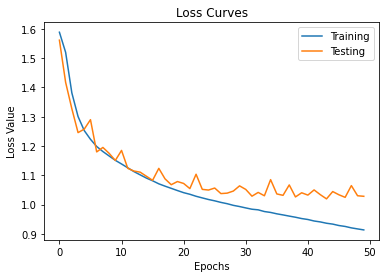

In [22]:
plt.plot(list(range(len(tloss))), tloss, label="Training")
plt.plot(list(range(len(vloss))), vloss, label = "Testing")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title("Loss Curves")

Text(0.5, 1.0, 'Accuracy Value')

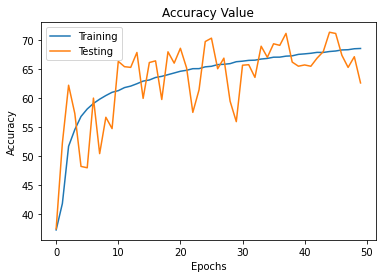

In [23]:
plt.plot(list(range(len(tacc))), tacc, label="Training")
plt.plot(list(range(len(vacc))), vacc, label = "Testing")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Value")

In [24]:
pos_sent = "This food was good but i didn't like the place. Although, love the desert!"

pos_rev = SENT_FIELD.process([SENT_FIELD.preprocess(pos_sent)])

net.eval()
pred = net(pos_rev.to(dev))

print("Review Rating as predicted : {}".format(pred.topk(1)[1].item() + 1))

Review Rating as predicted : 3


In [25]:
pos_sent = "I just hated that food. Not recommended at all."

pos_rev = SENT_FIELD.process([SENT_FIELD.preprocess(pos_sent)])

net.eval()
pred = net(pos_rev.to(dev))

print("Review Rating as predicted : {}".format(pred.topk(1)[1].item() + 1))

Review Rating as predicted : 1


In [ ]:
vocab_dict = {}
for z in range(len(SENT_FIELD.vocab)):
    vocab_dict[SENT_FIELD.vocab.itos[z]] = z

import pickle

with open("./vocabdict.pkl", "wb") as f:
    pickle.dump([vocab_dict], f)